In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Library

In [ ]:
# LIBRARY

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

# --- Implementasi Algoritma ---

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn import tree
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import Data

In [ ]:
# Import Data

url=""
df_rawdata = pd.read_excel(url)

In [ ]:
df_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDPEL        400 non-null    int64  
 1   TARIF        400 non-null    object 
 2   DAYA         400 non-null    int64  
 3   RP/KWH       400 non-null    float64
 4   AVG_TAGIHAN  400 non-null    float64
 5   PENGHASILAN  400 non-null    object 
 6   STATUS       400 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 22.0+ KB


In [ ]:
# Cek data duplikat
df_rawdata.duplicated().sum()

0

In [ ]:
df_cust = df_rawdata[['TARIF', 'DAYA', 'RP/KWH', 'AVG_TAGIHAN', 'PENGHASILAN', 'STATUS']]

# Data Preparation

In [ ]:
# Mengecek missing value dari data
df_cust.isnull().sum()

,0
TARIF,0
DAYA,0
RP/KWH,0
AVG_TAGIHAN,0
PENGHASILAN,0
STATUS,0


In [ ]:
df_cust.isna().sum()

,0
TARIF,0
DAYA,0
RP/KWH,0
AVG_TAGIHAN,0
PENGHASILAN,0
STATUS,0


In [ ]:
df_cust.head()

,TARIF,DAYA,RP/KWH,AVG_TAGIHAN,PENGHASILAN,STATUS
0,R1,1300,1440.7,514894.333333,sedang,Y
1,R1M,900,1352.0,231525.750000,sedang,N
2,R1M,900,1352.0,249643.000000,sedang,N
3,R1,1300,1440.7,76649.700000,sedang,Y
4,R1M,900,1352.0,316828.833333,sedang,Y


## Distribusi Data

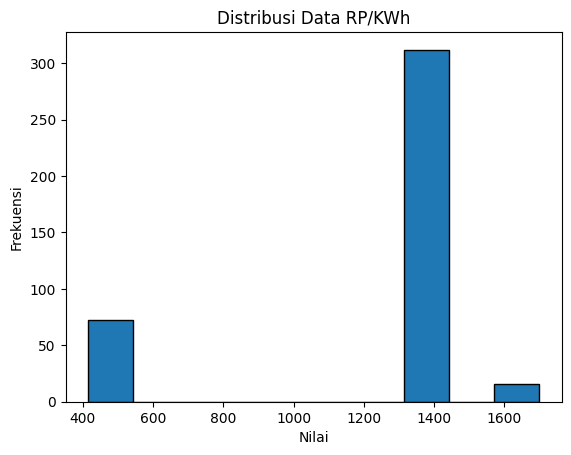

In [ ]:
# Sebaran Nilai Tagihan

df_cust['RP/KWH'].plot(kind='hist', edgecolor='black')
plt.title('Distribusi Data RP/KWh')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')

# Menampilkan histogram
plt.show()

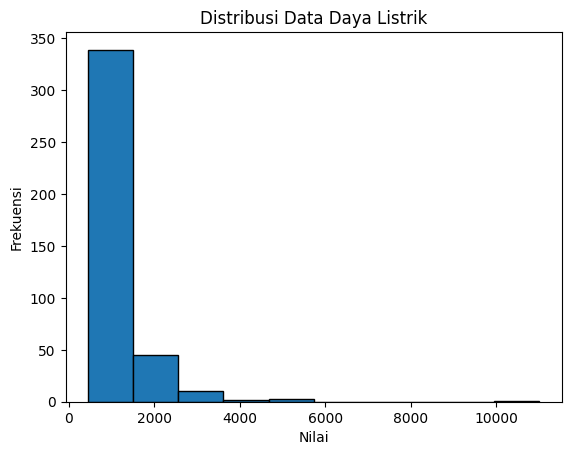

In [ ]:
# Sebaran Nilai Tagihan

df_cust['DAYA'].plot(kind='hist', edgecolor='black')
plt.title('Distribusi Data Daya Listrik')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')

# Menampilkan histogram
plt.show()

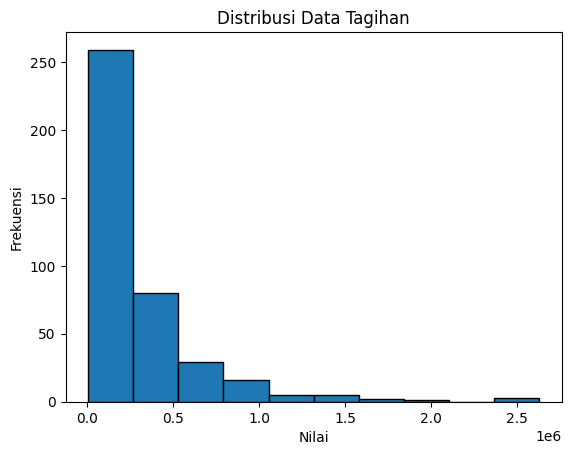

In [ ]:
# Sebaran Nilai Tagihan

df_cust['AVG_TAGIHAN'].plot(kind='hist', edgecolor='black')
plt.title('Distribusi Data Tagihan')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')

# Menampilkan histogram
plt.show()

## Data Transformation

In [ ]:
df_cust['Status'] = df_cust['STATUS'].map({'Y':0,'N':1})
df_cust['Penghasilan'] = df_cust['PENGHASILAN'].map({'rendah':1,'sedang':2, 'tinggi':3})
df_cust['Tarif'] = df_cust['TARIF'].map({'R1M':1,'R1':1, 'R2' :2, 'R3' :3})

In [ ]:
df_cust.head(10)

,TARIF,DAYA,RP/KWH,AVG_TAGIHAN,PENGHASILAN,STATUS,Status,Penghasilan,Tarif
0,R1,1300,1440.7,514894.333333,sedang,Y,0,2,1
1,R1M,900,1352.0,231525.750000,sedang,N,1,2,1
2,R1M,900,1352.0,249643.000000,sedang,N,1,2,1
3,R1,1300,1440.7,76649.700000,sedang,Y,0,2,1
4,R1M,900,1352.0,316828.833333,sedang,Y,0,2,1
5,R1,450,415.0,21969.050000,sedang,Y,0,2,1
6,R1M,900,1352.0,265694.833333,sedang,Y,0,2,1
7,R1,450,415.0,39004.033333,sedang,Y,0,2,1
8,R1,1300,1440.7,399372.166667,sedang,Y,0,2,1
9,R1,2200,1440.7,262960.500000,sedang,Y,0,2,1


## Data Preprocessing

In [ ]:
# Equal-frequency binning untuk membagi tagihan

df_cust['Tagihan'] = pd.qcut(df_cust['AVG_TAGIHAN'], q=4, labels=['1', '2', '3', '4'])

# Tampilkan range interval pada tiap kategori
intervals = pd.qcut(df_cust['AVG_TAGIHAN'], q=4)

print("\nRange interval pada tiap kategori:")
kategori_intervals = {}
for label in df_cust['Tagihan'].cat.categories:
    mask = df_cust['Tagihan'] == label
    kategori_intervals[label] = (df_cust.loc[mask, 'AVG_TAGIHAN'].min(), df_cust.loc[mask, 'AVG_TAGIHAN'].max())

for label, (min_val, max_val) in kategori_intervals.items():
    print(f"Kategori {label}: {min_val} - {max_val}")


Range interval pada tiap kategori:
Kategori 1: 5242.691459999999 - 87579.4813405
Kategori 2: 87885.87116666666 - 188780.98683333336
Kategori 3: 190925.4931 - 375970.65349999996
Kategori 4: 376217.3333333333 - 2628694.712383333


In [ ]:
# Equal Frequency Binning untuk mengkategorikan daya

num_bins = 3
df_cust['Daya'] = pd.qcut(df_cust['DAYA'], q=num_bins, labels=['1', '2', '3'])

# Tampilkan range interval pada tiap kategori
intervals = pd.qcut(df_cust['DAYA'], q=3)

print("\nRange interval pada tiap kategori:")
kategori_intervals = {}
for label in df_cust['Daya'].cat.categories:
    mask = df_cust['Daya'] == label
    kategori_intervals[label] = (df_cust.loc[mask, 'DAYA'].min(), df_cust.loc[mask, 'DAYA'].max())

for label, (min_val, max_val) in kategori_intervals.items():
    print(f"Kategori {label}: {min_val} - {max_val}")


Range interval pada tiap kategori:
Kategori 1: 450 - 900
Kategori 2: 1300 - 1300
Kategori 3: 2200 - 11000


In [ ]:
# Equal Frequency Binning untuk mengkategorikan biaya/kwh

num_bins = 3
df_cust['Biayakwh'] = pd.qcut(df_cust['RP/KWH'], q=num_bins, labels=['1', '2', '3'])

# Tampilkan range interval pada tiap kategori
intervals = pd.qcut(df_cust['RP/KWH'], q=3)

print("\nRange interval pada tiap kategori:")
kategori_intervals = {}
for label in df_cust['Biayakwh'].cat.categories:
    mask = df_cust['Biayakwh'] == label
    kategori_intervals[label] = (df_cust.loc[mask, 'DAYA'].min(), df_cust.loc[mask, 'RP/KWH'].max())

for label, (min_val, max_val) in kategori_intervals.items():
    print(f"Kategori {label}: {min_val} - {max_val}")


Range interval pada tiap kategori:
Kategori 1: 450 - 1352.0
Kategori 2: 1300 - 1440.7
Kategori 3: 3500 - 1699.53


In [ ]:
df_cust.head()

,TARIF,DAYA,RP/KWH,AVG_TAGIHAN,PENGHASILAN,STATUS,Status,Penghasilan,Tarif,Tagihan,Daya,Biayakwh
0,R1,1300,1440.7,514894.333333,sedang,Y,0,2,1,4,2,2
1,R1M,900,1352.0,231525.750000,sedang,N,1,2,1,3,1,1
2,R1M,900,1352.0,249643.000000,sedang,N,1,2,1,3,1,1
3,R1,1300,1440.7,76649.700000,sedang,Y,0,2,1,1,2,2
4,R1M,900,1352.0,316828.833333,sedang,Y,0,2,1,3,1,1


In [ ]:
# Melakukan seleksi untuk dataset yang sudah selesai ditransformasi

df_clean = df_cust[['Tarif', 'Penghasilan', 'Tagihan', 'Daya', 'Biayakwh', 'Status']]

In [ ]:
df_clean.head()

,Tarif,Penghasilan,Tagihan,Daya,Biayakwh,Status
0,1,2,4,2,2,0
1,1,2,3,1,1,1
2,1,2,3,1,1,1
3,1,2,1,2,2,0
4,1,2,3,1,1,0


## Uji Chi-Square Variabel Independen - Dependen


### TARIF - STATUS

In [ ]:
contingency_table = pd.crosstab(df_clean['Tarif'], df_clean['Status'])

# Melakukan uji chi-square
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil uji chi-square
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degree of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-square statistic: 6.347031963470321
p-value: 0.041856173343309794
Degree of freedom: 2
Expected frequencies table:
[[3.50400e+02 3.36000e+01]
 [1.36875e+01 1.31250e+00]
 [9.12500e-01 8.75000e-02]]


### TAGIHAN - STATUS

In [ ]:
contingency_table = pd.crosstab(df_clean['Tagihan'], df_clean['Status'])

# Melakukan uji chi-square
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil uji chi-square
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degree of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-square statistic: 9.362035225048924
p-value: 0.024845287604622353
Degree of freedom: 3
Expected frequencies table:
[[91.25  8.75]
 [91.25  8.75]
 [91.25  8.75]
 [91.25  8.75]]


### DAYA - LABEL

In [ ]:
contingency_table = pd.crosstab(df_clean['Daya'], df_clean['Status'])

# Melakukan uji chi-square
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil uji chi-square
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degree of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-square statistic: 12.276831814763465
p-value: 0.002158339922050676
Degree of freedom: 2
Expected frequencies table:
[[227.2125  21.7875]
 [ 82.125    7.875 ]
 [ 55.6625   5.3375]]


### PENGHASILAN - STATUS

In [ ]:
contingency_table = pd.crosstab(df_clean['Penghasilan'], df_clean['Status'])

# Melakukan uji chi-square
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil uji chi-square
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degree of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-square statistic: 1.2315436319874353
p-value: 0.5402237810079098
Degree of freedom: 2
Expected frequencies table:
[[ 59.3125   5.6875]
 [193.45    18.55  ]
 [112.2375  10.7625]]


### RP/KWH - STATUS

In [ ]:
contingency_table = pd.crosstab(df_clean['Biayakwh'], df_clean['Status'])

# Melakukan uji chi-square
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil uji chi-square
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degree of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-square statistic: 10.489795668868123
p-value: 0.005274360525119956
Degree of freedom: 2
Expected frequencies table:
[[227.2125  21.7875]
 [123.1875  11.8125]
 [ 14.6      1.4   ]]


Hasil perhitungan dengan menggunakan chi square berdasarkan nilai p-value:
1. Tarif : 0.04
2. Tagihan : 0.02
3. Daya : 0.002
4. Penghasilan : 0.54
5. Biayakwh : 0.005


## Uji Feature Importance

In [ ]:
df_clean.head()

,Tarif,Penghasilan,Tagihan,Daya,Biayakwh,Status
0,1,2,4,2,2,0
1,1,2,3,1,1,1
2,1,2,3,1,1,1
3,1,2,1,2,2,0
4,1,2,3,1,1,0


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Tarif        400 non-null    int64   
 1   Penghasilan  400 non-null    int64   
 2   Tagihan      400 non-null    category
 3   Daya         400 non-null    category
 4   Biayakwh     400 non-null    category
 5   Status       400 non-null    int64   
dtypes: category(3), int64(3)
memory usage: 11.1 KB


In [ ]:
df_clean['Tagihan'] = df_clean['Tagihan'].astype('int')
df_clean['Daya'] = df_clean['Daya'].astype('int')
df_clean['Biayakwh'] = df_clean['Biayakwh'].astype('int')

<ipython-input-30-698c562de153>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Tagihan'] = df_clean['Tagihan'].astype('int')
<ipython-input-30-698c562de153>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Daya'] = df_clean['Daya'].astype('int')
<ipython-input-30-698c562de153>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [ ]:
X = df_clean.drop(columns='Status')
y = df_clean['Status']

Akurasi: 0.7462121212121212


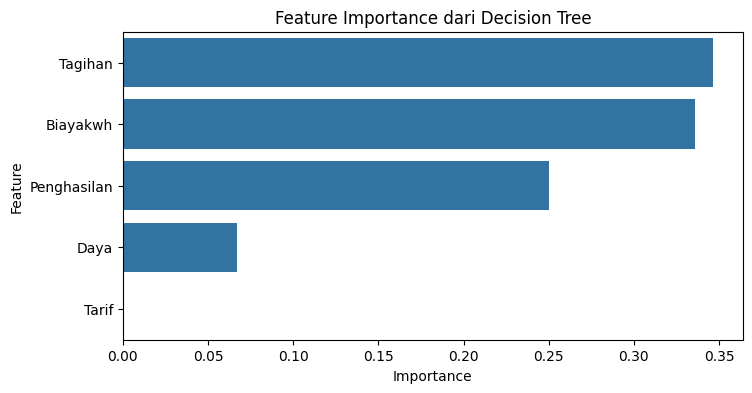

       Feature  Importance
2      Tagihan    0.346712
4     Biayakwh    0.336038
1  Penghasilan    0.250457
3         Daya    0.066792
0        Tarif    0.000000


In [ ]:
X = df_clean.drop(columns=['Status'])
y = df_clean['Status']

# Membuat pipeline dengan oversampling dan undersampling
pipeline = Pipeline(steps=[
    ('over', SMOTE(sampling_strategy = 0.3, random_state=42)),  # Oversampling dengan SMOTE
    ('under', RandomUnderSampler(sampling_strategy = 0.7, random_state=42))  # Undersampling dengan RandomUnderSampler
])

# Menggunakan pipeline untuk melakukan resampling pada data
X_resampled, y_resampled = pipeline.fit_resample(X, y)

# Membuat model Decision Tree dengan kriteria entropy
clf = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=7, max_features=7)

# Cross-validation dengan 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(clf, X_resampled, y_resampled, cv=cv, scoring='accuracy')

# Latih model pada seluruh data pelatihan
clf.fit(X_resampled, y_resampled)

# Evaluasi model pada data pelatihan (atau data pengujian jika ada)
y_pred = clf.predict(X_resampled)
y_pred_proba = clf.predict_proba(X_resampled)[:, 1]  # Probabilitas untuk kelas negatif (1)
accuracy = accuracy_score(y_resampled, y_pred)
print(f'Akurasi: {accuracy}')

# Mendapatkan feature importance
feature_importances = clf.feature_importances_

# Membuat DataFrame untuk feature importance
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Mengurutkan berdasarkan importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Menampilkan feature importance
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance dari Decision Tree')
plt.show()

print(importance_df)

# Implementasi Algoritma

In [ ]:
df_clean['Status'].value_counts()

,count
Status,
0,365
1,35


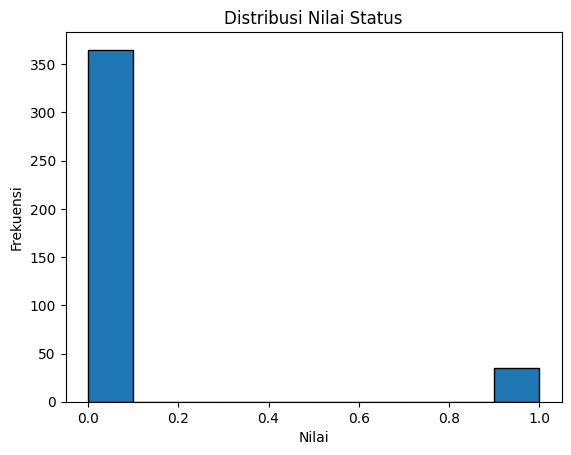

In [ ]:
# Sebaran Nilai Tagihan

df_clean['Status'].plot(kind='hist', edgecolor='black')
plt.title('Distribusi Nilai Status')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')

# Menampilkan histogram
plt.show()

## Menggunakan SMOTE

In [ ]:
# Menggunakan SMOTE untuk oversampling
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Membuat model Decision Tree dengan kriteria entropy
clf = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=7)

# Cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(clf, X_resampled, y_resampled, cv=cv, scoring='accuracy')

# Latih model pada seluruh data pelatihan
clf.fit(X_resampled, y_resampled)

y_pred = clf.predict(X_resampled)
y_pred_proba = clf.predict_proba(X_resampled)[:, 1]  # Probabilitas untuk kelas minoritas
accuracy = accuracy_score(y_resampled, y_pred)

# Hitung Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_resampled, y_pred_proba)
pr_auc = auc(recall, precision)

# Hitung ROC AUC
roc_auc = roc_auc_score(y_resampled, y_pred_proba)

print(f'Rata-rata Skor Cross-Validation: {np.mean(cross_val_scores)}')
print(f'Akurasi pada Data Pengujian: {accuracy}')
print(f'Precision-Recall AUC: {pr_auc}')
print(f'ROC AUC: {roc_auc}')
print('Laporan Klasifikasi:')
print(classification_report(y_resampled, y_pred))

Rata-rata Skor Cross-Validation: 0.767123287671233
Akurasi pada Data Pengujian: 0.7780821917808219
Precision-Recall AUC: 0.7882282067023473
ROC AUC: 0.8320623006192531
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.86      0.66      0.75       365
           1       0.73      0.90      0.80       365

    accuracy                           0.78       730
   macro avg       0.79      0.78      0.77       730
weighted avg       0.79      0.78      0.77       730



## Menggunakan Undersampling

In [ ]:
# Menggunakan RandomUnderSampler untuk undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Membuat model Decision Tree dengan kriteria entropy
clf = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=7)

# Cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(clf, X_resampled, y_resampled, cv=cv, scoring='accuracy')

# Latih model pada seluruh data pelatihan
clf.fit(X_resampled, y_resampled)

# Evaluasi model pada data pelatihan (atau data pengujian jika ada)
y_pred = clf.predict(X_resampled)
y_pred_proba = clf.predict_proba(X_resampled)[:, 1]  # Probabilitas untuk kelas minoritas
accuracy = accuracy_score(y_resampled, y_pred)

# Hitung Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_resampled, y_pred_proba)
pr_auc = auc(recall, precision)

roc_auc = roc_auc_score(y_resampled, y_pred_proba)

print(f'Rata-rata Skor Cross-Validation: {np.mean(cross_val_scores)}')
print(f'Akurasi pada Data Pengujian: {accuracy}')
print(f'Precision-Recall AUC: {pr_auc}')
print(f'ROC AUC: {roc_auc}')
print('Laporan Klasifikasi:')
print(classification_report(y_resampled, y_pred))

Rata-rata Skor Cross-Validation: 0.5
Akurasi pada Data Pengujian: 0.6714285714285714
Precision-Recall AUC: 0.7902717802663588
ROC AUC: 0.7681632653061224
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.62      0.86      0.72        35
           1       0.77      0.49      0.60        35

    accuracy                           0.67        70
   macro avg       0.70      0.67      0.66        70
weighted avg       0.70      0.67      0.66        70



## Menggabungkan Oversampling dan Undersampling

In [ ]:
from imblearn.pipeline import Pipeline

# Membuat pipeline dengan oversampling dan undersampling
pipeline = Pipeline(steps=[
    ('over', SMOTE(sampling_strategy = 0.3, random_state=42)),  # Oversampling
    ('under', RandomUnderSampler(sampling_strategy = 0.7, random_state=42))  # Undersampling
])

# Menggunakan pipeline untuk melakukan resampling pada data
X_resampled, y_resampled = pipeline.fit_resample(X, y)

# Membuat model Decision Tree dengan kriteria entropy
clf = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=7)

# Cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(clf, X_resampled, y_resampled, cv=cv, scoring='accuracy', )

# Latih model pada seluruh data pelatihan
clf.fit(X_resampled, y_resampled)

# Evaluasi model pada data pelatihan (atau data pengujian jika ada)
y_pred = clf.predict(X_resampled)
y_pred_proba = clf.predict_proba(X_resampled)[:, 1]  # Probabilitas untuk kelas minoritas
accuracy = accuracy_score(y_resampled, y_pred)

# Hitung Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_resampled, y_pred_proba)
pr_auc = auc(recall, precision)

roc_auc = roc_auc_score(y_resampled, y_pred_proba)


print(f'Rata-rata Skor Cross-Validation: {np.mean(cross_val_scores)}')
print(f'Akurasi pada Data Pengujian: {accuracy}')
print(f'Precision-Recall AUC: {pr_auc}')
print(f'ROC AUC: {roc_auc}')
print('Laporan Klasifikasi:')
print(classification_report(y_resampled, y_pred))

Rata-rata Skor Cross-Validation: 0.7196969696969697
Akurasi pada Data Pengujian: 0.7462121212121212
Precision-Recall AUC: 0.7390314206550715
ROC AUC: 0.8168984906777154
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       155
           1       0.68      0.74      0.71       109

    accuracy                           0.75       264
   macro avg       0.74      0.75      0.74       264
weighted avg       0.75      0.75      0.75       264



# Evaluasi Model

## Kurva ROC AUC

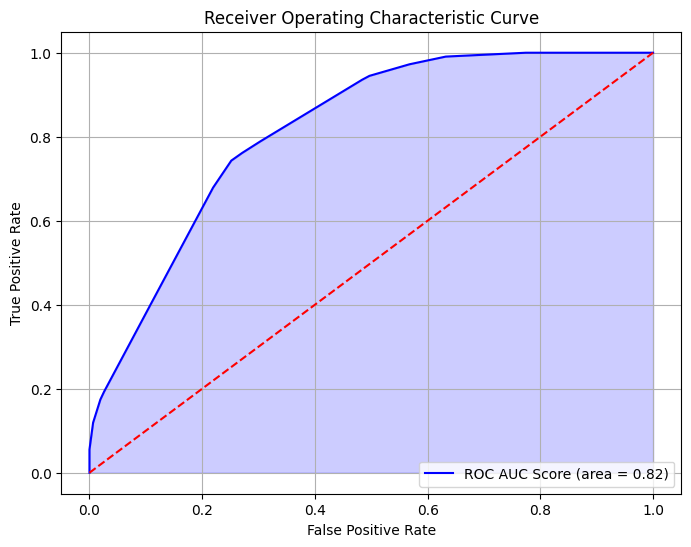

In [ ]:
# Hitung probabilitas prediksi
y_pred_proba = clf.predict_proba(X_resampled)[:, 1]

# Hitung ROC Curve
fpr, tpr, thresholds = roc_curve(y_resampled, y_pred_proba)

# Hitung ROC AUC
roc_auc = roc_auc_score(y_resampled, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC AUC Score (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')  # Mengisi area di bawah kurva
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Kurva PR-AUC

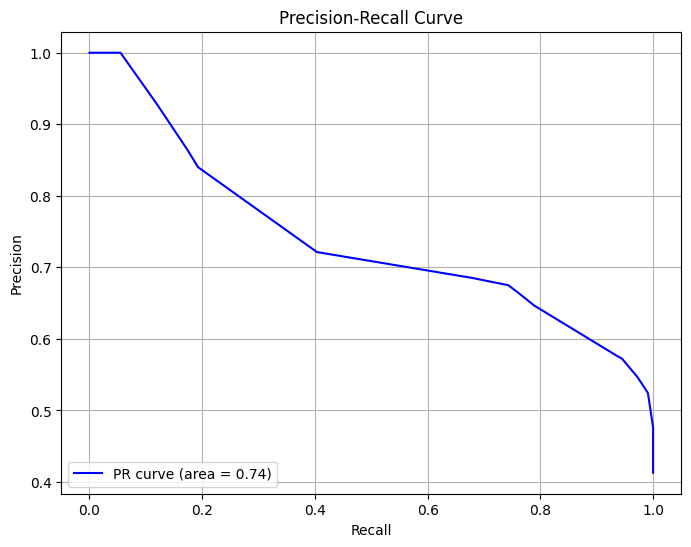

In [ ]:
# Hitung probabilitas prediksi
y_pred_proba = clf.predict_proba(X_resampled)[:, 1]

# Hitung Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_resampled, y_pred_proba)

# Hitung Precision-Recall AUC
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

plt.show()

## Confusion Matrix

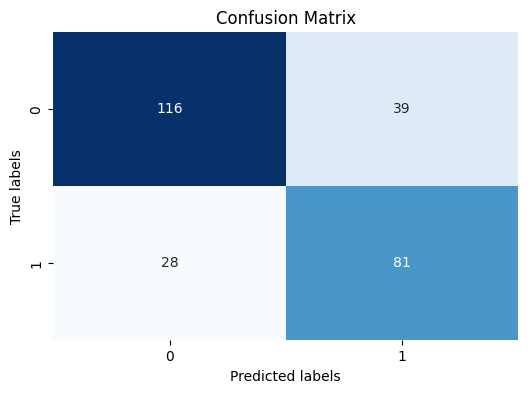

In [ ]:
cm = confusion_matrix(y_resampled, y_pred)

# Menampilkan confusion matrix dengan heatmap (menggunakan seaborn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Visualisasi Pohon Keputusan

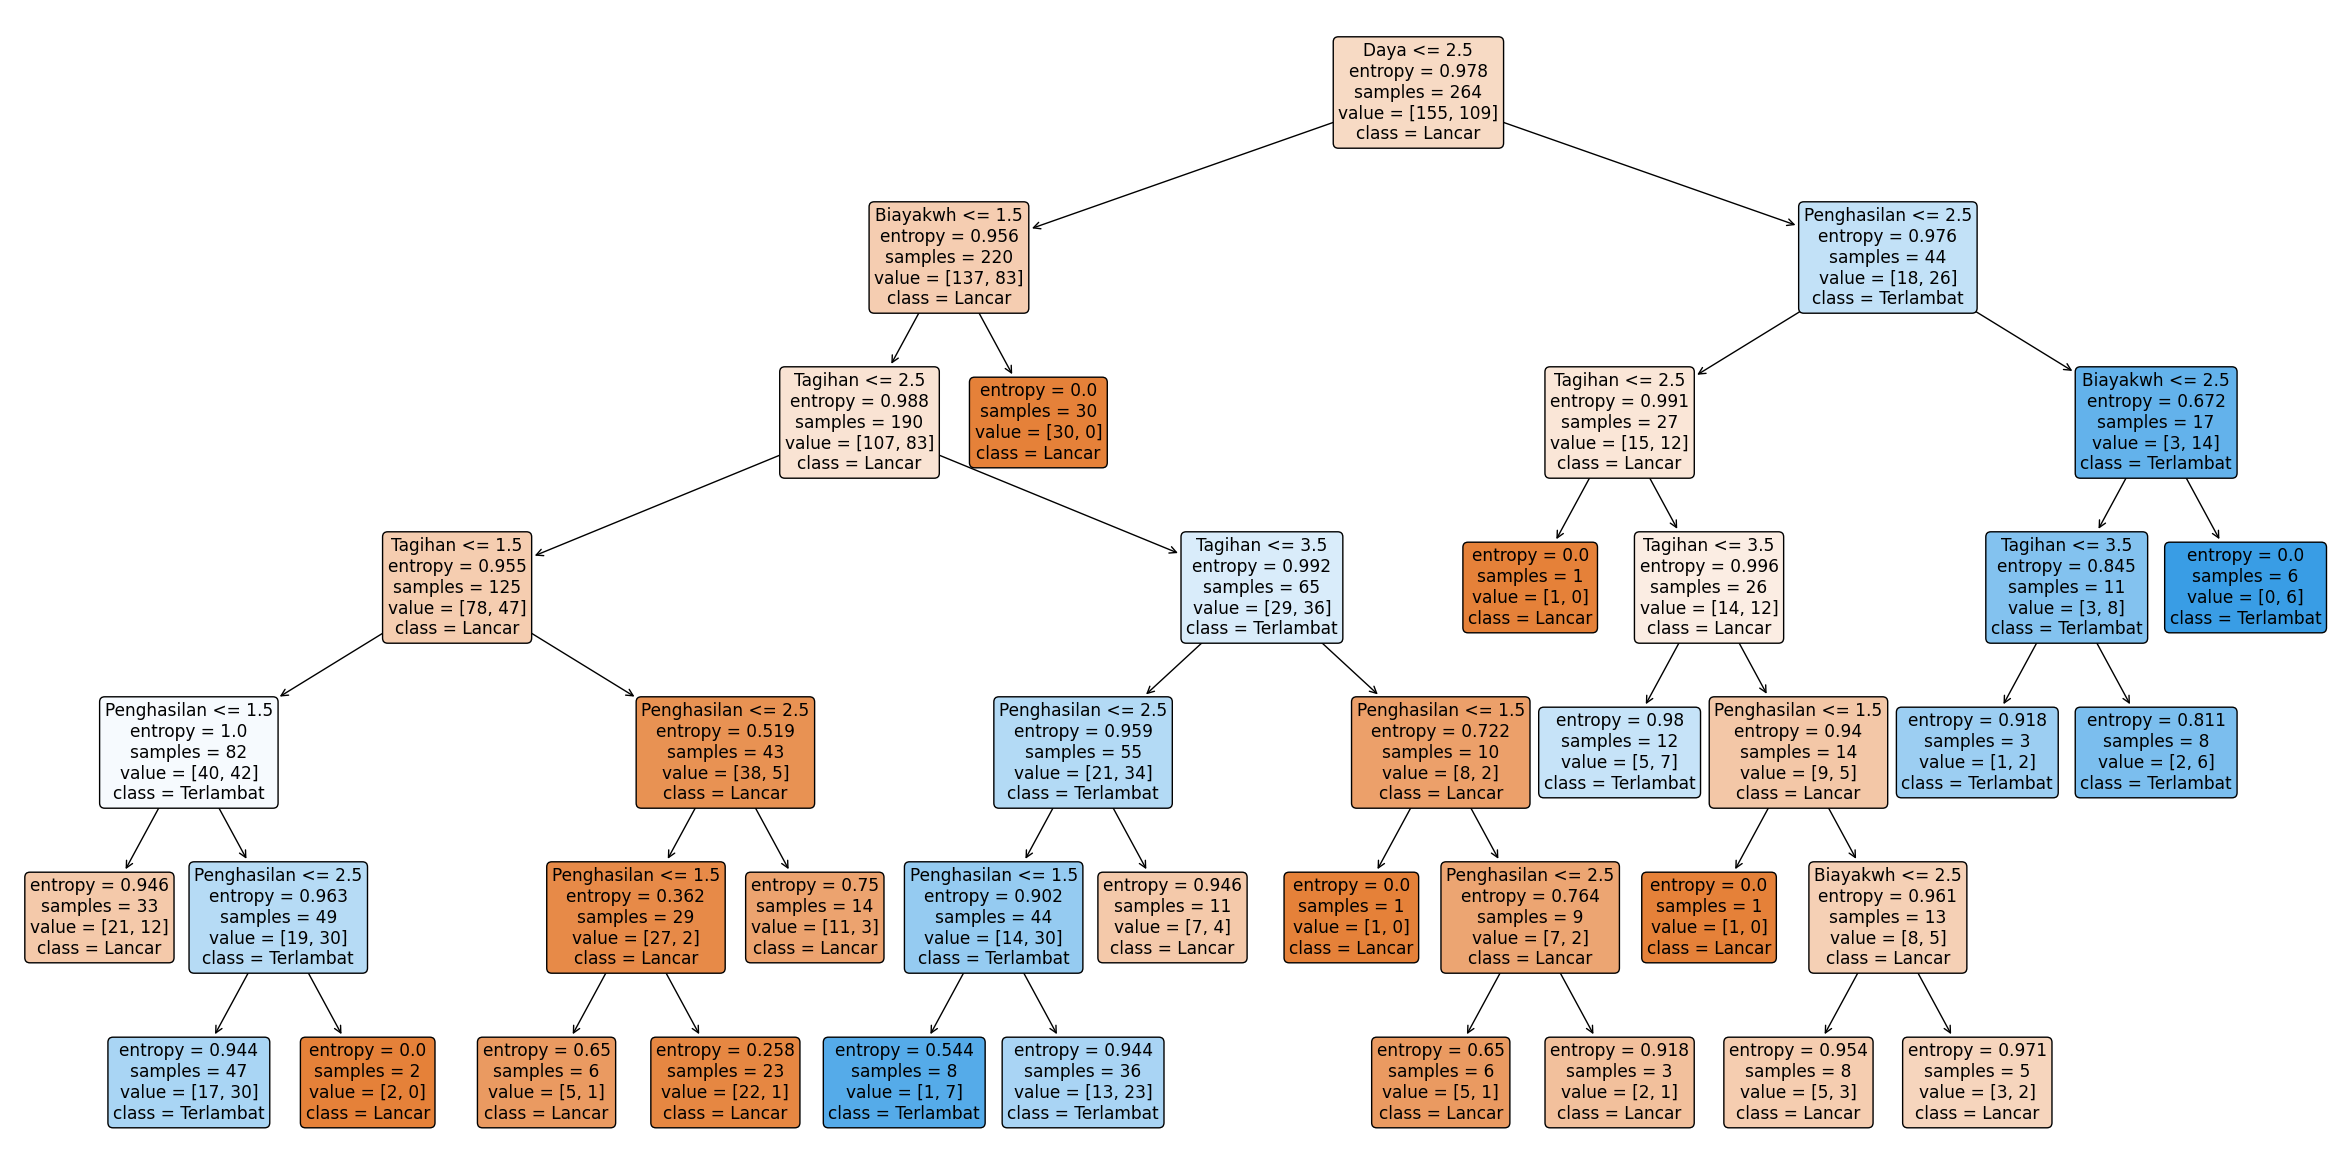

In [ ]:
plt.figure(figsize=(30,15))
plot_tree(clf, feature_names=['Tarif',	'Penghasilan',	'Tagihan',	'Daya',	'Biayakwh'], class_names=['Lancar', 'Terlambat'], filled=True, rounded=True)
plt.show()

In [ ]:
result_df = pd.DataFrame(X_resampled, columns=X.columns)
result_df['Actual'] = y_resampled
result_df['Predicted'] = y_pred

print(result_df.tail())

     Tarif  Penghasilan  Tagihan  Daya  Biayakwh  Actual  Predicted
469      1            1        1     1         1       1          0
470      1            2        1     1         1       1          1
471      1            3        3     3         2       1          1
472      1            2        1     1         1       1          1
473      1            2        3     1         1       1          1


# Import Model Ke Pickle

In [ ]:
# with open('c45.pkl', 'wb') as file:
  #  pickle.dump(clf, file)